In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [2]:
words = open("names.txt").read().splitlines()

In [3]:
unique_chars = sorted(list(set("".join(words))))
stoi = {c: i+1 for i, c in enumerate(unique_chars)}
stoi["."] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# create training set:
xs, ys = [], []

for w in words:
    chars = [".", "."] + list(w) + ["."]
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        idx3 = stoi[char3]
        # print(char1, char2, char3)
        xs.append([idx1, idx2])
        ys.append(idx3)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [5]:
xs[:10]

tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1],
        [ 0,  0],
        [ 0, 15],
        [15, 12],
        [12,  9],
        [ 9, 22]])

In [6]:
ys.shape

torch.Size([228146])

In [7]:
xs.shape

torch.Size([228146, 2])

In [8]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

In [9]:
xenc1 = F.one_hot(xs[:,0], num_classes=27).float()
xenc1.shape

torch.Size([228146, 27])

In [10]:
xenc2 = F.one_hot(xs[:,1], num_classes=27).float()
xenc2.shape

torch.Size([228146, 27])

In [11]:
xenc12 = torch.cat([xenc1, xenc2], dim=1)
xenc12.shape

torch.Size([228146, 54])

In [12]:
xenc12[12]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
(xenc12 @ W).shape

torch.Size([228146, 27])

In [14]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

In [15]:
# apply gradient descent
losses = []
for _ in range(100):
    # forward pass
    xenc1 = F.one_hot(xs[:,0], num_classes=27).float()
    xenc2 = F.one_hot(xs[:,1], num_classes=27).float()
    xenc12 = torch.cat([xenc1, xenc2], dim=1)
    logits = xenc12 @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # loss
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + 0.1 * (W ** 2).mean()
    print(loss.item())
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -10 * W.grad

4.329545021057129


/home/u229589/workspace/private/Andrej-Karpathy-Zero-To-Hero/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


4.080554008483887
3.8978171348571777
3.756769895553589
3.641490936279297
3.5430538654327393
3.4580018520355225
3.384303092956543
3.3202128410339355
3.264178991317749
3.2148759365081787
3.171208620071411
3.132293462753296
3.097419261932373
3.066009759902954
3.037592649459839
3.0117721557617188
2.9882142543792725
2.966632127761841
2.9467766284942627
2.928433656692505
2.91141676902771
2.89556622505188
2.880744695663452
2.866834878921509
2.8537375926971436
2.841367244720459
2.829653024673462
2.8185324668884277
2.807952880859375
2.7978689670562744
2.788240671157837
2.77903413772583
2.770218849182129
2.761768102645874
2.753657102584839
2.745865821838379
2.7383744716644287
2.7311651706695557
2.72422194480896
2.717531442642212
2.7110793590545654
2.7048537731170654
2.698842763900757
2.6930367946624756
2.6874256134033203
2.6820003986358643
2.6767525672912598
2.6716740131378174
2.6667580604553223
2.661996603012085
2.657383918762207
2.6529133319854736
2.6485793590545654
2.644375801086426
2.6402976

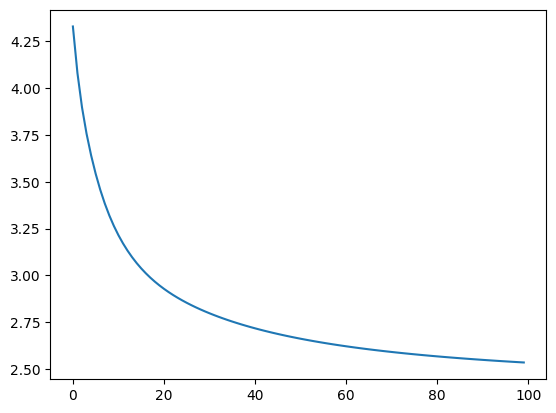

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [17]:
for _ in range(10):

    sampled_name = []
    idxs = [0, 0]

    while True:
        xenc1 = F.one_hot(torch.tensor([idxs[0]]), num_classes=27).float()
        xenc2 = F.one_hot(torch.tensor([idxs[1]]), num_classes=27).float()
        xenc12 = torch.cat([xenc1, xenc2], dim=1)
        logits = xenc12 @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        # probs = torch.ones((27)).float()/27 # uniform sampling

        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        sampled_name.append(itos[idx])

        if itos[idx] == ".":
            break;
        idxs[0] = idxs[1]
        idxs[1] = idx
    print("".join(sampled_name))    

tworani.
ies.
le.
iaitoin.
alox.
allirasn.
ha.
ri.
halayly.
gvkbejhtaere.


### create Train/Test/Valid split

In [18]:
# create training set:
def create_xy_samples(words: list[str]) -> tuple[list[torch.TensorType], list[torch.TensorType]]:
    xs, ys = [], []

    for w in words:
        chars = [".", "."] + list(w) + ["."]
        for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
            idx1 = stoi[char1]
            idx2 = stoi[char2]
            idx3 = stoi[char3]
            # print(char1, char2, char3)
            xs.append([idx1, idx2])
            ys.append(idx3)
        
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [19]:
total_size = len(words)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size
(train_size, valid_size, test_size)

(25626, 3203, 3204)

In [20]:
shuffeld_words_idx = torch.randperm(len(words))

In [21]:
train_idx = shuffeld_words_idx[:train_size]
valid_idx = shuffeld_words_idx[train_size:(train_size+valid_size)]
test_idx = shuffeld_words_idx[(train_size+valid_size):]
test_idx.shape

torch.Size([3204])

In [22]:
train_words = [words[idx] for idx in train_idx]
valid_words = [words[idx] for idx in valid_idx]
test_words = [words[idx] for idx in test_idx]

In [23]:
Xtr, Ytr = create_xy_samples(train_words)
Xva, Yva = create_xy_samples(valid_words)
Xte, Yte = create_xy_samples(test_words)
Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182583, 2]),
 torch.Size([182583]),
 torch.Size([22704, 2]),
 torch.Size([22704]),
 torch.Size([22859, 2]),
 torch.Size([22859]))

In [24]:
# train trigram NN
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

xenc1 = F.one_hot(Xtr[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xtr[:,1], num_classes=27).float()
xenc = torch.cat([xenc1, xenc2], dim=1)

xenc1 = F.one_hot(Xva[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xva[:,1], num_classes=27).float()
xenc_valid = torch.cat([xenc1, xenc2], dim=1)

start_time = time.time()
losses = []
valid_losses = []
for _ in range(100):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # loss
    loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean() + 1 * (W ** 2).mean()
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -5 * W.grad

    with torch.no_grad():
        logits_val = xenc_valid @ W
        counts_val = logits_val.exp()
        probs_val = counts_val / counts_val.sum(dim=1, keepdim=True)

        loss_valid = -probs_val[torch.arange(Xva.shape[0]), Yva].log().mean()
        valid_losses.append(loss_valid.item())

    print(loss.item(), loss_valid.item())

print(f"time used: {time.time() - start_time}")

5.202478408813477 4.094376087188721
5.037905693054199 3.976118326187134
4.896047115325928 3.8736002445220947
4.771401405334473 3.7840495109558105
4.661001682281494 3.7051210403442383
4.5623369216918945 3.6346750259399414
4.4731364250183105 3.5709731578826904
4.391556739807129 3.5127692222595215
4.3162713050842285 3.4592270851135254
4.246377944946289 3.409778118133545
4.1812520027160645 3.364008665084839
4.120429039001465 3.3215856552124023
4.063530445098877 3.2822206020355225
4.010227203369141 3.245654582977295
3.960221290588379 3.211649179458618
3.9132399559020996 3.1799826622009277
3.869032382965088 3.150454521179199
3.8273684978485107 3.1228792667388916
3.7880377769470215 3.097087860107422
3.750850200653076 3.0729286670684814
3.715632915496826 3.0502634048461914
3.682229995727539 3.0289695262908936
3.6505017280578613 3.00893497467041
3.620321273803711 2.9900596141815186
3.5915753841400146 2.9722533226013184
3.5641610622406006 2.9554336071014404
3.5379838943481445 2.9395267963409424


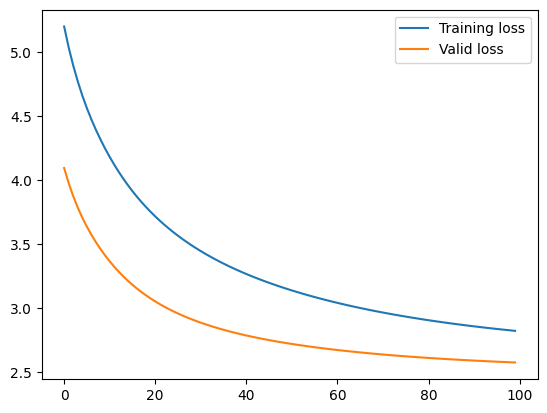

In [25]:
plt.plot(torch.arange(len(losses)), losses)
plt.plot(torch.arange(len(valid_losses)), valid_losses)
plt.legend(["Training loss", "Valid loss"])

In [ ]:
# c          train loss     |   valid loss
# c = 100    -> 3.2539732456207275 3.2154977321624756
# c =  10    -> 3.0265824794769287 2.866492748260498
# c =   1    -> 2.8211441040039062 2.568406343460083
# c =   0.1  -> 2.666152238845825 2.597468137741089
# c =   0.01 -> 2.616381883621216 2.6072781085968018
# c = 0.0..1 -> 2.6101174354553223 2.6084816455841064


In [26]:
# evaluate on test set

# forward pass
xenc1 = F.one_hot(Xte[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xte[:,1], num_classes=27).float()
xenc_test = torch.cat([xenc1, xenc2], dim=1)
logits_test = xenc_test @ W
counts_test = logits_test.exp()
probs_test = counts_test / counts_test.sum(dim=1, keepdim=True)

# loss
loss = -probs_test[torch.arange(Xte.shape[0]), Yte].log().mean()
print(loss.item())

2.5678369998931885


### Convert One Hot Encoding to direct indexing

In [36]:
xs_train_idx = Xtr[:5,:] + torch.tensor((0, 27))
xs_train_idx

tensor([[ 0, 27],
        [ 0, 33],
        [ 6, 28],
        [ 1, 50],
        [23, 41]])

5.202478408813477 4.094371318817139
5.037900924682617 3.97611665725708
4.896045684814453 3.873596429824829
4.771397590637207 3.784048318862915
4.660999774932861 3.705120086669922
4.562335968017578 3.6346733570098877
4.473134517669678 3.5709710121154785
4.391554832458496 3.5127673149108887
4.316269874572754 3.4592251777648926
4.246376037597656 3.4097766876220703
4.18125057220459 3.3640072345733643
4.120427131652832 3.3215839862823486
4.063529014587402 3.2822201251983643
4.010226249694824 3.2456541061401367
3.9602208137512207 3.2116479873657227
3.9132394790649414 3.1799826622009277
3.869032144546509 3.15045428276062
3.8273680210113525 3.122878313064575
3.788037061691284 3.0970866680145264
3.750849485397339 3.0729269981384277
3.7156317234039307 3.050262689590454
3.682229518890381 3.0289692878723145
3.650501251220703 3.008934259414673
3.620321035385132 2.9900588989257812
3.5915751457214355 2.972252368927002
3.5641603469848633 2.955432891845703
3.5379834175109863 2.9395267963409424
3.512960

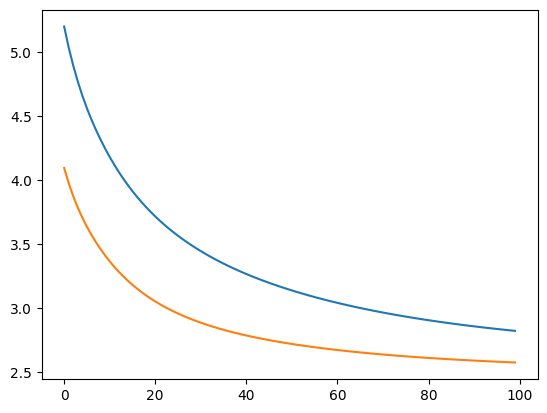

In [37]:
# train trigram NN
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

losses = []
valid_losses = []
start_time = time.time()
for _ in range(100):
    # forward pass
    logits = W[Xtr[:,0]] + W[(Xtr[:,1]+torch.tensor((27)))]
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # loss
    loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean() + 1 * (W ** 2).mean()
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -5 * W.grad

    with torch.no_grad():
        logits_val = W[Xva[:,0]] + W[(Xva[:,1]+torch.tensor((27)))]
        counts_val = logits_val.exp()
        probs_val = counts_val / counts_val.sum(dim=1, keepdim=True)

        loss_valid = -probs_val[torch.arange(Xva.shape[0]), Yva].log().mean()
        valid_losses.append(loss_valid.item())

    print(loss.item(), loss_valid.item())

print(f"time used: {time.time() - start_time}")
plt.plot(torch.arange(len(losses)), losses)
plt.plot(torch.arange(len(valid_losses)), valid_losses)

### Use F.cross_entropy

In [38]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

xenc1 = F.one_hot(Xtr[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xtr[:,1], num_classes=27).float()
xenc = torch.cat([xenc1, xenc2], dim=1)

xenc1 = F.one_hot(Xva[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xva[:,1], num_classes=27).float()
xenc_valid = torch.cat([xenc1, xenc2], dim=1)

In [39]:
logits = xenc @ W
logits.shape

torch.Size([182583, 27])

In [40]:
F.one_hot(Ytr, num_classes=27).float().shape

torch.Size([182583, 27])

In [41]:
F.cross_entropy(logits, F.one_hot(Ytr, num_classes=27).float()).item()

4.232438087463379

5.202478885650635 4.094376087188721
5.037906169891357 3.976118564605713
4.896047592163086 3.8735997676849365
4.771401882171631 3.7840499877929688
4.661001205444336 3.705120801925659
4.5623369216918945 3.6346747875213623
4.473135948181152 3.5709729194641113
4.391556739807129 3.5127692222595215
4.316271781921387 3.4592270851135254
4.246377468109131 3.409778356552124
4.181251525878906 3.364008665084839
4.120429039001465 3.3215854167938232
4.063530445098877 3.2822206020355225
4.010227203369141 3.245654582977295
3.960221290588379 3.21164870262146
3.9132399559020996 3.1799826622009277
3.869032859802246 3.150454521179199
3.8273684978485107 3.1228790283203125
3.7880377769470215 3.097087860107422
3.750850200653076 3.0729284286499023
3.715632915496826 3.0502636432647705
3.6822304725646973 3.0289692878723145
3.650501251220703 3.00893497467041
3.620321750640869 2.9900596141815186
3.5915751457214355 2.9722533226013184
3.5641608238220215 2.9554331302642822
3.5379843711853027 2.9395270347595215
3.512

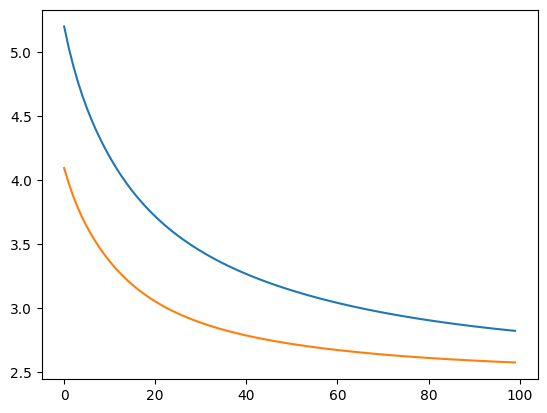

In [42]:
# train trigram NN
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

xenc1 = F.one_hot(Xtr[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xtr[:,1], num_classes=27).float()
xenc = torch.cat([xenc1, xenc2], dim=1)

xenc1 = F.one_hot(Xva[:,0], num_classes=27).float()
xenc2 = F.one_hot(Xva[:,1], num_classes=27).float()
xenc_valid = torch.cat([xenc1, xenc2], dim=1)

start_time = time.time()
losses = []
valid_losses = []
for _ in range(100):
    # forward pass
    logits = xenc @ W

    loss = F.cross_entropy(logits, F.one_hot(Ytr, num_classes=27).float()) + 1 * (W ** 2).mean()
    # counts = logits.exp()
    # probs = counts / counts.sum(dim=1, keepdim=True)

    # # loss
    # loss = -probs[torch.arange(xs_train.shape[0]), ys_train].log().mean() + 1 * (W ** 2).mean()
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -5 * W.grad

    with torch.no_grad():
        logits_val = xenc_valid @ W
        loss_valid = F.cross_entropy(logits_val, F.one_hot(Yva, num_classes=27).float())
        # counts_val = logits_val.exp()
        # probs_val = counts_val / counts_val.sum(dim=1, keepdim=True)

        # loss_valid = -probs_val[torch.arange(xs_valid.shape[0]), ys_valid].log().mean()
        valid_losses.append(loss_valid.item())

    print(loss.item(), loss_valid.item())
    # print(loss.item())

print(f"time used: {time.time() - start_time}")
plt.plot(torch.arange(len(losses)), losses)
plt.plot(torch.arange(len(valid_losses)), valid_losses)